# Modelo de lenguaje con tokenización por palabras

## Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

In [67]:
import os
import random


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [62]:
RANDOM_SEED = 5440
BATCH_SIZE = 32

Así como lo hicimos en el desafío anterior, buscamos las diferentes recetas del mismo. Para simplificar el desarrollo del TP, voy a replicar algunas funciones, aunque la idea en un entorno producitvo es tener locaciones comunes, librerías estandars de recupero y manipulación de la información.

In [4]:
def get_recipes_files(folder_paths):
    files = []
    for folder_path in folder_paths:
        files.extend([os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.txt') or file.endswith('.md')])
    return files

In [5]:
folder_paths = ['../Desafio 2/recipes_1', '../Desafio 2/recipes_2']
all_files = get_recipes_files(folder_paths)
print("All files:")
print(all_files)

All files:
['../Desafio 2/recipes_1/almonds.txt', '../Desafio 2/recipes_1/fava.txt', '../Desafio 2/recipes_1/squares.txt', '../Desafio 2/recipes_1/recipes2.txt', '../Desafio 2/recipes_1/brownies.txt', '../Desafio 2/recipes_1/pannacotta.txt', '../Desafio 2/recipes_1/bruschetta.txt', '../Desafio 2/recipes_1/sweet_potato_pie.txt', '../Desafio 2/recipes_1/sorbet.txt', '../Desafio 2/recipes_1/cauli.txt', '../Desafio 2/recipes_1/tart.txt', '../Desafio 2/recipes_1/cornbread.txt', '../Desafio 2/recipes_2/crispy-beef-with-egg-fried-rice.md', '../Desafio 2/recipes_2/classic-duck-breast.md', '../Desafio 2/recipes_2/crispy-sesame-chicken.md', '../Desafio 2/recipes_2/tomato-pasta.md', '../Desafio 2/recipes_2/beef-stroganoff.md', '../Desafio 2/recipes_2/carrot-cake.md', '../Desafio 2/recipes_2/cacio-e-peppe.md', '../Desafio 2/recipes_2/pizza-sauce.md', '../Desafio 2/recipes_2/tagliatelle-with-broccoli-cauliflower-and-blue-cheese.md', '../Desafio 2/recipes_2/pizza-dogs.md', '../Desafio 2/recipes_2/me

In [6]:
# El encoding latin-1 es necesario para leer los archivos de texto. Si no se especifica, se produce un error de UnicodeDecodeError:
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 2: invalid continuation byte
df_recipes = pd.DataFrame({'recipe': [open(file, encoding='latin-1').read() for file in all_files]})

In [7]:
print("Cantidad de documentos:", df_recipes.shape[0])

Cantidad de documentos: 80


In [8]:
df_recipes

,recipe
0,"BLANCHING NUTS: In the case of nuts, especiall..."
1,(fava beans)\n\ntreat gently when young and fr...
2,"These are kid tested, mother approved. From Co..."
3,\nless.\n\n1 cup dried split peas 1/2 teaspoon...
4,Fooder's Brownies (I usually 1/2 the recipe to...
...,...
75,---\ntitle: Beef and Guinness stew\ndate: 2021...
76,---\ntitle: Margherita pizza\ndate: 2021-07-18...
77,---\ntitle: Whisky Haggis sauce\ndate: 2023-01...
78,---\ntitle: Bosnian Stuffed Peppers (Punjene P...


Con esto me estoy asegurando que voy a trabajar con los mismos 80 documentos que el TP anterior.

In [15]:
def split_recipes_into_lines(df, column_name):
    """
    Esta función toma un DataFrame y el nombre de una columna que contiene recetas.
    Devuelve una lista donde cada elemento es un renglón de las recetas.
    """
    lines = []
    for recipe in df[column_name]:
        lines.extend(recipe.split('\n'))
    return lines

# Uso de la función
recipe_lines = split_recipes_into_lines(df_recipes, 'recipe')
print("Algunos ejemplos",recipe_lines[:10])

print("Cantidad de líneas:", len(recipe_lines))

Algunos ejemplos ['BLANCHING NUTS: In the case of nuts, especially with almonds, pistachios ', 'and hazelnuts, in addition to the tough outer husk, they have a thin inner ', 'lining which needs to be removed. This lining can be bitter and somewhat ', 'unattractive when found in confection and baked goods. Blanching can be a ', 'time consuming process. Think about  purchasing them already blanched and ', 'skinned. Nuts can then be chopped and then toasted, if desired.', '', 'ALMONDS:\t', 'Shell almonds and place them in a saucepan. Cover them with water.  ', '']
Cantidad de líneas: 6462


In [16]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in recipe_lines]

Comparamos ahora entonces alguna entrada randmom. El objetivo es ver como se ha segmentado una línea de las recetas.

In [36]:
random_idx = random.randint(0, len(segmented_sentences))
print(recipe_lines[random_idx])
print(segmented_sentences[random_idx])

soft, about 14 minutes. Using slotted spoon, transfer vegetables to 
['soft', 'about', '14', 'minutes', 'using', 'slotted', 'spoon', 'transfer', 'vegetables', 'to']


#### Histograma
Vamos a evaluar el histograma de las longitud de las secuencias que nos permitirán buscar el hiperparámetro deseado.

In [22]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

print(length_sentences)

[11, 14, 13, 12, 10, 11, 0, 1, 12, 0, 13, 0, 13, 13, 12, 0, 14, 14, 1, 0, 0, 0, 4, 0, 2, 0, 2, 7, 3, 0, 5, 0, 5, 6, 6, 4, 0, 13, 2, 0, 15, 3, 0, 0, 0, 8, 0, 15, 17, 11, 0, 0, 0, 0, 0, 2, 0, 12, 0, 6, 0, 7, 0, 15, 15, 15, 2, 0, 13, 0, 16, 5, 0, 15, 13, 6, 0, 6, 0, 13, 0, 14, 15, 15, 15, 15, 14, 14, 14, 12, 12, 13, 1, 0, 9, 0, 12, 15, 7, 0, 12, 0, 10, 16, 14, 14, 15, 14, 14, 14, 15, 14, 13, 14, 5, 0, 13, 0, 6, 0, 0, 14, 16, 14, 1, 0, 5, 0, 0, 0, 0, 0, 0, 2, 6, 6, 6, 12, 6, 6, 5, 8, 0, 0, 0, 14, 13, 16, 17, 1, 14, 15, 11, 1, 0, 15, 12, 15, 14, 12, 9, 0, 14, 8, 0, 14, 15, 10, 0, 10, 0, 3, 0, 1, 5, 3, 4, 0, 1, 3, 4, 5, 6, 4, 5, 4, 4, 0, 5, 0, 14, 14, 13, 11, 14, 8, 0, 14, 12, 13, 13, 1, 0, 0, 6, 0, 0, 0, 0, 2, 0, 13, 1, 0, 1, 4, 3, 5, 0, 1, 6, 2, 5, 5, 2, 0, 0, 17, 15, 14, 14, 6, 0, 13, 11, 11, 13, 13, 1, 0, 0, 0, 3, 0, 0, 7, 5, 13, 2, 5, 6, 8, 5, 2, 0, 16, 13, 12, 10, 0, 14, 14, 7, 0, 11, 0, 2, 0, 2, 2, 5, 0, 0, 1, 0, 19, 14, 0, 16, 12, 0, 15, 7, 0, 17, 8, 0, 4, 0, 0, 0, 6, 0, 15, 14, 18, 

(array([4.799e+03, 1.005e+03, 4.240e+02, 9.200e+01, 4.500e+01, 2.600e+01,
        2.500e+01, 1.200e+01, 8.000e+00, 7.000e+00, 6.000e+00, 3.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([  0. ,   7.2,  14.4,  21.6,  28.8,  36. ,  43.2,  50.4,  57.6,
         64.8,  72. ,  79.2,  86.4,  93.6, 100.8, 108. , 115.2, 122.4,
        129.6, 136.8, 144. ]),
 <BarContainer object of 20 artists>)

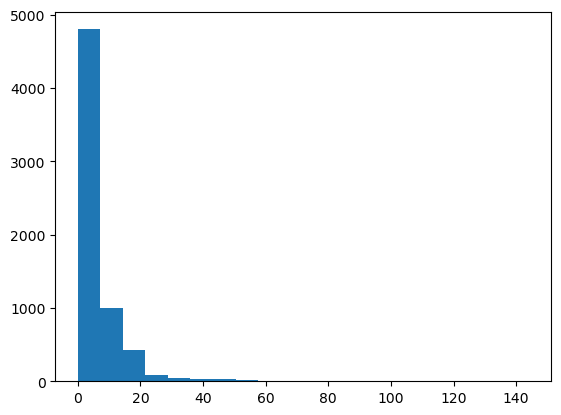

In [25]:
# Distribución de la longitud de las secuencias
plt.hist(length_sentences,bins=20)

Ahora, apartir de la distribución de longitudes de secuencias elegimos algún criterio.

Vamos a evaluar diferentes criquerios.

In [26]:

# el -1 es porque el último token será el target
max_context_size_percentile = int(np.percentile(length_sentences, 90)-1)
print(f'max_context_size (Percentile): {max_context_size_percentile}')

max_context_size_mean = int(np.ceil(np.mean(length_sentences))) # criterio de media
print(f'max_context_size (Media): {max_context_size_mean}')

max_context_size_median = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size (Mediana): {max_context_size_median}')


max_context_size (Percentile): 14
max_context_size (Media): 6
max_context_size (Mediana): 3


Vamos a elegir la media. Ya que parece un tamaño bastante adecuado.

In [27]:
max_context_size = max_context_size_mean

###  Tokenizar
A partir de lo obtenido ahora, vamos a tokenizar

In [30]:
tok = Tokenizer()

tok.fit_on_texts(segmented_sentences)

tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [37]:
tokenized_sentences[random_idx]

[394, 64, 463, 9, 217, 1719, 268, 407, 322, 5]

In [38]:
segmented_sentences[0]

['blanching',
 'nuts',
 'in',
 'the',
 'case',
 'of',
 'nuts',
 'especially',
 'with',
 'almonds',
 'pistachios']

Vamos ahora a armar los dataset (entrenamiento y validación)

In [41]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=RANDOM_SEED)

Ahora voy a relizar un split de las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento.

In [42]:
tokenized_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tokenized_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tokenized_sent.append(sent)

In [43]:
len(tokenized_sent)

18128

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

In [44]:
tokenized_sent_augm = []

for sent in tokenized_sent:
  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tokenized_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [45]:
# Finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tokenized_sent_augm, axis=0)

In [46]:
train_seqs.shape

(91489, 7)

## Obtenemos el vector input y el target

In [47]:

X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [48]:
# Verficiamos el shape del target
y.shape

(91489, 6)

In [56]:
# Palabras del vocabulario
tok.index_word.values()

dict_values(['the', 'and', '1', 'a', 'to', '2', 'in', 'of', 'minutes', 'with', 'for', 'add', '4', 'time', 'or', 'https', '3', 'com', 'until', 'chicken', 'it', 'into', 'cook', 'pan', 'is', 'on', 'oil', 'butter', 'sugar', 'cup', 'sauce', 'heat', 'salt', 'pasta', 'flour', 'issue', 'from', 'tbsp', 'ingredients', 'tsp', '5', 'i', 'garlic', 'water', 'serves', 'chopped', 'oven', 'jcallaghan', 'you', 'github', 'then', 'cookbook', 'baking', 'jpg', 'images', 'image', 'this', 'large', 'over', 'style', '10', 'stir', 'at', 'about', 'id', 'bowl', 'mix', '6', 'chocolate', 'bake', 'place', '15', 'ingredient', 'serve', '8', 'eggs', 'cups', 'recipe', 'pepper', 'prep', 'as', '20', 'cheese', 'user', 'main', 'if', 'remove', 'issues', 'githubusercontent', '7449908', 'some', 'total', 'can', 'cream', 'medium', 'cut', 'milk', 'rice', 'title', 'method', 'recipes', 'date', 'link', 'thumbnail', 'labels', 'all', 'vanilla', 'but', 'teaspoon', 'favourite', 'top', 'dish', 'taste', 'finely', 'ð\x9f¥°', 'pictures', 'we

In [57]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3948

In [58]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'and': 2, '1': 3, 'a': 4, 'to': 5, '2': 6, 'in': 7, 'of': 8, 'minutes': 9, 'with': 10, 'for': 11, 'add': 12, '4': 13, 'time': 14, 'or': 15, 'https': 16, '3': 17, 'com': 18, 'until': 19, 'chicken': 20, 'it': 21, 'into': 22, 'cook': 23, 'pan': 24, 'is': 25, 'on': 26, 'oil': 27, 'butter': 28, 'sugar': 29, 'cup': 30, 'sauce': 31, 'heat': 32, 'salt': 33, 'pasta': 34, 'flour': 35, 'issue': 36, 'from': 37, 'tbsp': 38, 'ingredients': 39, 'tsp': 40, '5': 41, 'i': 42, 'garlic': 43, 'water': 44, 'serves': 45, 'chopped': 46, 'oven': 47, 'jcallaghan': 48, 'you': 49, 'github': 50, 'then': 51, 'cookbook': 52, 'baking': 53, 'jpg': 54, 'images': 55, 'image': 56, 'this': 57, 'large': 58, 'over': 59, 'style': 60, '10': 61, 'stir': 62, 'at': 63, 'about': 64, 'id': 65, 'bowl': 66, 'mix': 67, '6': 68, 'chocolate': 69, 'bake': 70, 'place': 71, '15': 72, 'ingredient': 73, 'serve': 74, '8': 75, 'eggs': 76, 'cups': 77, 'recipe': 78, 'pepper': 79, 'prep': 80, 'as': 81, '20': 82, 'cheese': 83, 'user': 

In [59]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'the': 1005, 'case': 2, 'especially': 2, 'pistachios': 1, 'almonds': 5, 'with': 339, 'of': 381, 'nuts': 15, 'blanching': 2, 'in': 411, 'addition': 7, 'inner': 1, 'thin': 13, 'and': 877, 'have': 46, 'they': 26, 'to': 554, 'tough': 2, 'hazelnuts': 2, 'husk': 1, 'outer': 5, 'a': 596, 'this': 90, 'can': 66, 'somewhat': 2, 'be': 51, 'which': 12, 'lining': 3, 'bitter': 6, 'removed': 4, 'needs': 5, 'found': 6, 'goods': 1, 'confection': 1, 'when': 38, 'baked': 13, 'unattractive': 1, 'think': 7, 'process': 4, 'about': 89, 'them': 53, 'already': 1, 'purchasing': 1, 'consuming': 3, 'time': 265, 'blanched': 4, 'skinned': 2, 'toasted': 13, 'if': 73, 'desired': 6, 'chopped': 112, 'then': 105, 'saucepan': 25, 'water': 112, 'shell': 8, 'place': 82, 'cover': 27, 'rinse': 1, '2': 511, 'cold': 17, 'boil': 34, 'for': 323, 'drain': 27, '3': 237, 'minutes': 395, 'end': 4, 'by': 37, 'your': 45, 'pinch': 29, 'skins': 1, 'at': 88, 'almond': 6, 'one': 55, 'off': 44, 'holding': 1, 'pr

# Modelo

## 1. Definir el modelo

In [60]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          197450    
                                                                 
 lstm (LSTM)                 (None, None, 100)         60400     
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         80400     
                                                                 
 dense (Dense)               (None, None, 3949)        398849    
                                                                 
Total params: 737,099
Trainable params: 737,099
Non-trainable params: 0
_________________________________________________________________


#### Vamos a construir la función de perplejidad mediante el uso de una función callback

In [61]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


## 2. Entrenar el modelo

In [64]:
BATCH_SIZE = 64 if BATCH_SIZE is None else BATCH_SIZE

In [65]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=BATCH_SIZE)

Epoch 1/20
2854/2860 [============================>.] - ETA: 0s - loss: 4.3917
 mean perplexity: 3111.2932747402465 



INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
2860/2860 [==============================] - 31s 11ms/step - loss: 4.3911
Epoch 2/20
2857/2860 [============================>.] - ETA: 0s - loss: 4.1579
 mean perplexity: 2710.6658974718052 



INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
2860/2860 [==============================] - 38s 13ms/step - loss: 4.1578
Epoch 3/20
2858/2860 [============================>.] - ETA: 0s - loss: 3.9664
 mean perplexity: 2638.948308202524 



INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
2860/2860 [==============================] - 43s 15ms/step - loss: 3.9665
Epoch 4/20
2860/2860 [==============================] - ETA: 0s - loss: 3.8093
 mean perplexity: 2659.156278218665 

2860/2860 [==============================] - 45s 16ms/step - loss: 3.8093
Epoch 5/20
2857/2860 [============================>.] - ETA: 0s - loss: 3.6687
 mean perplexity: 2839.1980046476588 

2860/2860 [==============================] - 47s 17ms/step - loss: 3.6686
Epoch 6/20
2860/2860 [==============================] - ETA: 0s - loss: 3.5415
 mean perplexity: 2817.8156745963124 

2860/2860 [==============================] - 47s 17ms/step - loss: 3.5415
Epoch 7/20
2857/2860 [============================>.] - ETA: 0s - loss: 3.4271
 mean perplexity: 2599.1877261774357 



INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
2860/2860 [==============================] - 53s 19ms/step - loss: 3.4270
Epoch 8/20
2859/2860 [============================>.] - ETA: 0s - loss: 3.3243
 mean perplexity: 2813.628910991008 

2860/2860 [==============================] - 43s 15ms/step - loss: 3.3243
Epoch 9/20
2856/2860 [============================>.] - ETA: 0s - loss: 3.2305
 mean perplexity: 2824.004454627454 

2860/2860 [==============================] - 45s 16ms/step - loss: 3.2305
Epoch 10/20
2856/2860 [============================>.] - ETA: 0s - loss: 3.1428
 mean perplexity: 4047.6347180212356 

2860/2860 [==============================] - 48s 17ms/step - loss: 3.1429
Epoch 11/20
2859/2860 [============================>.] - ETA: 0s - loss: 3.0625
 mean perplexity: 3470.2958125655864 

2860/2860 [==============================] - 47s 16ms/step - loss: 3.0625
Epoch 12/20
2860/2860 [==============================] - ETA: 0s - loss: 2.9853
 mean perplexity: 3349.430465229643 

Stopping training...
28

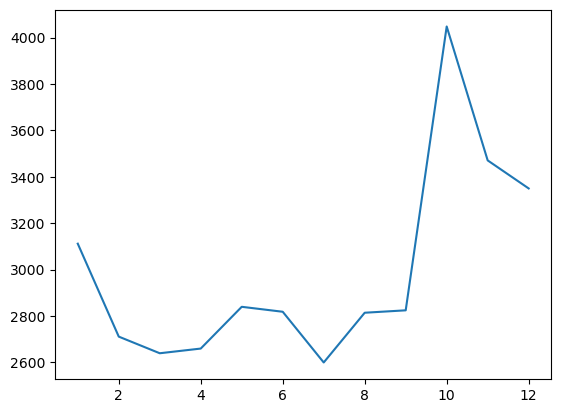

In [68]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [69]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model')

## 3. Predicción de próxima palabra

In [70]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [71]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

/opt/anaconda3/envs/Fabricio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 12ms/step
Keyboard interruption in main thread... closing server.


### 4. Generación de secuencias

In [72]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [75]:
input_text='add salt to the'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 9ms/step


'add salt to the pan and stir until the mixture is the pasta is'

### 5. Beam search y muestreo aleatorio

In [76]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [77]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

#### Predicción

In [94]:
inputs = ["add salt to the","put the chicken in the", "heat the oil in a", "add the flour to the", "mix the eggs with the"]

for input in inputs:
  print(f'Input: {input}')
  salida = beam_search(model,num_beams=10,num_words=6,input=input,temp=1,mode='sto')
  print(decode(salida[0]))


Input: add salt to the
['add salt to the pan and mix in the salmon']
Input: put the chicken in the
['put the chicken in the pan and mix in the further']
Input: heat the oil in a
['heat the oil in a medium heat and simmer for from']
Input: add the flour to the
['add the flour to the pan and stir in the oven']
Input: mix the eggs with the
['mix the eggs with the pan and mix in the wooden']
